In [ ]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, learning_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
import warnings
import gensim.corpora as corpora
from gensim.models import TfidfModel, Phrases
import numpy as np

warnings.filterwarnings('ignore')
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [ ]:
datas = pd.read_excel('/content/Data Final.xlsx')

## Preprocessing

In [ ]:
sw_list = set(stopwords.words('indonesian'))
stem = StemmerFactory()
stemmer = stem.create_stemmer()
sw_list.update(['more', 'rs', 'rumah', 'sakit','rsia', 'annisa', 'annissa',
                'anissa', 'anisa', 'arifin', 'ahmad', 'achmad', 'aulia', 'awal',
                'bros', 'eka', 'hermina', 'prima', 'lancang', 'kuning', 'sansani',
                'santa', 'maria', 'pekanbaru', 'dipekanbaru','syafira', 'hospital',
                'rssm', 'the', 'nya', 'riau', 'is', 'aamiin', 'hd', 'terima', 'kasih',
                'terimakasih'
                ])
to_remove = ['tidak', 'kurang', 'cukup', 'agak', 'sangat', 'sedikit', 'belum', 'terlalu']
sw_list = list(set(sw_list) - set(to_remove))
abb_dict_path = '/content/abbreviations_rev2.txt'

In [ ]:
def load(file): # Fungsi membaca kamus abbreviation (singkatan)
  f = open(file, "r")
  dic = {}
  for line in f:
    a,b = line.split(" = ")
    dic[a] = b[:-1]
  f.close()
  return dic

def change(text): # Fungsi merubah singkatan menjadi kata baku
  abb_dict = load(abb_dict_path)
  word = text.split()
  p = len(word)
  for i in range(p):
    if word[i] in abb_dict:
      word[i]=abb_dict[word[i]]
  return " ".join(word)

def remove_emoji(text): # Fungsi menghapus emoji
  emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoji umum
                               u"\U0001F300-\U0001F5FF"  # Simbol & Pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               u"\U0001F700-\U0001F77F"  # Alat & Kegiatan
                               u"\U0001F780-\U0001F7FF"  # Supplemental Symbols and Pictographs
                               u"\U0001F800-\U0001F8FF"  # Ideogram
                               u"\U0001F900-\U0001F9FF"  # Emoticons
                               u"\U0001FA00-\U0001FA6F"  # Supplemental Symbols and Pictographs
                               u"\U0001FA70-\U0001FAFF"  # Emoji Ekstensi
                               u"\U00002702-\U000027B0"  # Dingbat
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r' ', text)

  return text

def preprocessor(text):
  text = text.lower() # Case Folding
  text = remove_emoji(text) # Remove Emoji
  text = re.sub(r"[0-9]|[^\w\s]|_", " ", text) # Remove Number & Punct
  text = " ".join(text.split()) # Remove Whitespace
  text = re.sub("(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)", " ", text) # Remove Single Char
  text = change(text) # Text Normalization
  text = nltk.word_tokenize(text) # Tokenize
  text = [w for w in text if w not in sw_list] # Remove Stopwords
  text = " ".join(text)
  text = stemmer.stem(text) # Stemming

  return text

In [ ]:
datas['review'] = datas['review'].astype(str).apply(preprocessor)

In [ ]:
datas.to_excel('Cleaned Data Final.xlsx', index=False)

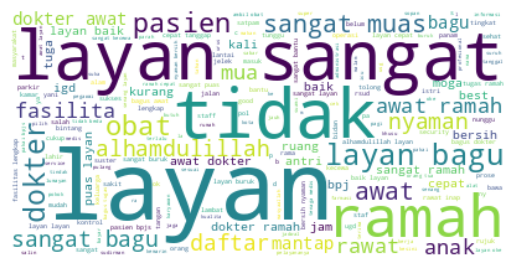

In [ ]:
# Visualisasi kumpulan kata
teks_string = datas['review'].dropna(ignore_index=True).to_string()

wordcloud = WordCloud(background_color="white")
wordcloud.generate(teks_string)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## LDA

In [ ]:
# Tokenisasi
import nltk
token_list = []

for i in datas['review']:
  indeks = nltk.word_tokenize(i)
  token_list.append(indeks)

In [ ]:
# Membangun dictionary
dictionary = corpora.Dictionary(token_list)
dictionary.filter_extremes(no_below=10, no_above=0.4)

In [ ]:
# Membangun model TF-IDF
doc_term_matrix = [dictionary.doc2bow(doc) for doc in token_list]
tfidf = TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

In [ ]:
from gensim.models import CoherenceModel
import gensim

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    perplexity_values = []

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, iterations=100, random_state=17)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [ ]:
start=1
limit=11
step=1
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary, corpus=corpus_tfidf, texts=token_list, start=start, limit=limit, step=step)

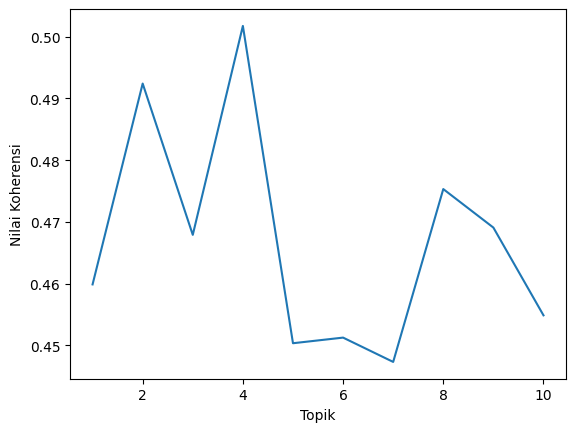

In [ ]:
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel('Topik')
plt.ylabel('Nilai Koherensi')
plt.show()

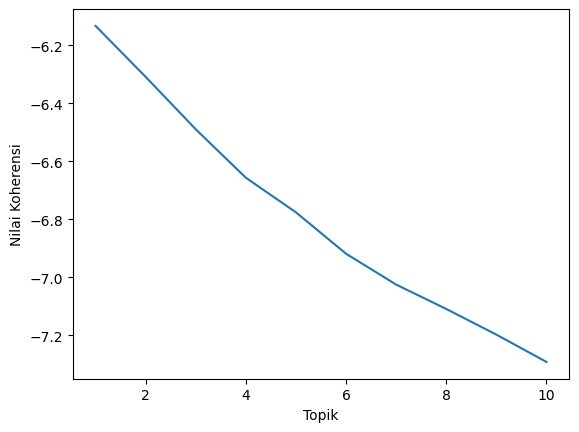

In [ ]:
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel('Topik')
plt.ylabel('Nilai Koherensi')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, "has Coherence Values of", round(cv,3) )

Num Topics = 1 has Coherence Values of 0.46
Num Topics = 2 has Coherence Values of 0.546
Num Topics = 3 has Coherence Values of 0.51
Num Topics = 4 has Coherence Values of 0.456
Num Topics = 5 has Coherence Values of 0.456
Num Topics = 6 has Coherence Values of 0.423
Num Topics = 7 has Coherence Values of 0.5
Num Topics = 8 has Coherence Values of 0.441
Num Topics = 9 has Coherence Values of 0.445
Num Topics = 10 has Coherence Values of 0.443


In [ ]:
from pprint import pprint
pprint(model_list[3].print_topics())

[(0,
  '0.056*"muas" + 0.041*"best" + 0.038*"baik" + 0.027*"sangat" + '
  '0.022*"alhamdulillah" + 0.021*"oke" + 0.020*"pokok" + 0.018*"good" + '
  '0.015*"medis" + 0.015*"karyawan"'),
 (1,
  '0.026*"tidak" + 0.018*"pasien" + 0.015*"rawat" + 0.014*"awat" + 0.013*"igd" '
  '+ 0.012*"dokter" + 0.011*"buruk" + 0.010*"kamar" + 0.010*"sangat" + '
  '0.010*"inap"'),
 (2,
  '0.024*"daftar" + 0.021*"jam" + 0.019*"antri" + 0.017*"tidak" + 0.015*"obat" '
  '+ 0.014*"parkir" + 0.013*"lahir" + 0.012*"pol" + 0.011*"dokter" + '
  '0.010*"tunggu"'),
 (3,
  '0.071*"bagus" + 0.063*"sangat" + 0.060*"ramah" + 0.036*"awat" + '
  '0.031*"nyaman" + 0.029*"muas" + 0.028*"bersih" + 0.027*"dokter" + '
  '0.026*"mantap" + 0.026*"tugas"')]


In [ ]:
!pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim
import pyLDAvis

pyLDAvis.enable_notebook()

model = model_list[8]
lda_vis_data = pyLDAvis.gensim.prepare(model, corpus_tfidf, dictionary)

In [ ]:
pyLDAvis.save_html(lda_vis_data, 'vis_LDA.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Read Data

In [ ]:
datas = pd.read_excel('/content/Data Final.xlsx', sheet_name='DataTrain')
datas['review'] = datas['review'].astype(str).apply(preprocessor)

In [ ]:
datas[['pelayanan', 'administrasi', 'kenyamanan', 'fasilitas']] = datas[['pelayanan', 'administrasi', 'kenyamanan', 'fasilitas']].fillna('none')
datas = datas.loc[~((datas['pelayanan'] == 'none') & (datas['administrasi'] == 'none') & (datas['kenyamanan'] == 'none') & (datas['fasilitas'] == 'none'))]
datas = datas.dropna(subset='review')
datas = datas.reset_index(drop=True)

# Feature Extraction

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,5))
X_tfidf = vectorizer.fit_transform(datas['review'])

# Pipeline

In [ ]:
import matplotlib.ticker as ticker

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=478)
smote = SMOTE(random_state=10)

classifiers = [
    ('Naive Bayes', naive_bayes.MultinomialNB()),
    ('k=3', KNeighborsClassifier(n_neighbors=3)),
]

pipelines = [(name, imb_Pipeline([
      ('smote', smote),
      ('clf', clf)
      ])) for name, clf in classifiers]

# ABSA

## Pelayanan

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : []
  }

  for train_index, test_index in kf.split(X_tfidf, datas['pelayanan']):
    x_train, x_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = datas['pelayanan'][train_index], datas['pelayanan'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)

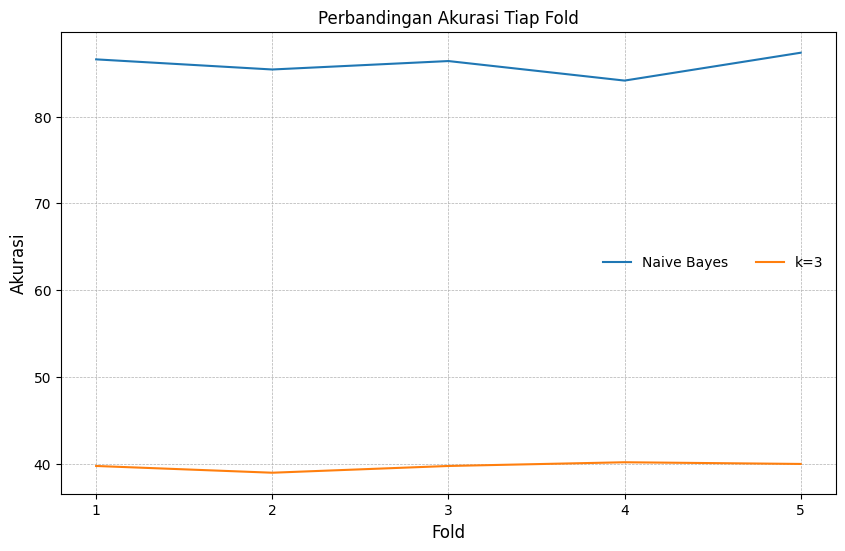

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [ ]:
pelayanan = pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/10 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

pelayanan

,1,2,3,4,5,Mean
Naive Bayes,86.6%,85.4%,86.4%,84.1%,87.4%,43.0%
k=3,39.7%,39.0%,39.7%,40.2%,40.0%,19.9%


## Administrasi

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : []
  }

  for train_index, test_index in kf.split(X_tfidf, datas['administrasi']):
    x_train, x_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = datas['administrasi'][train_index], datas['administrasi'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)

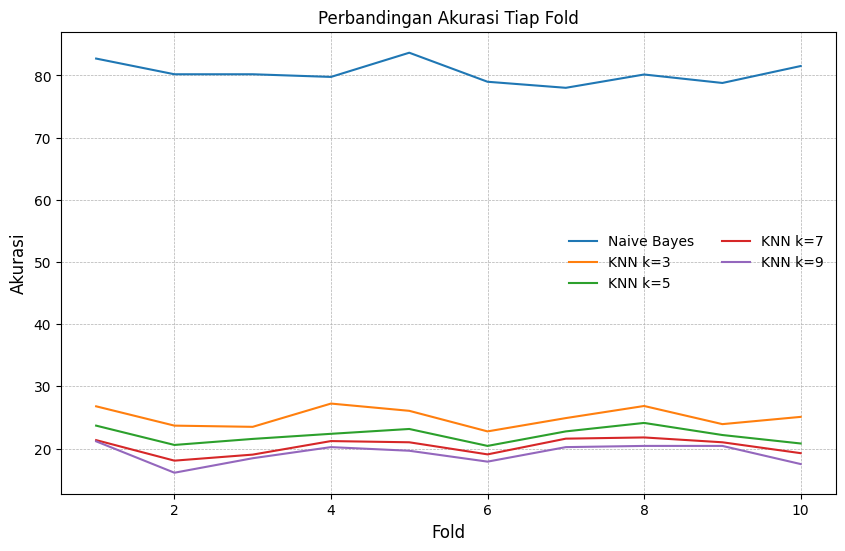

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
administrasi = pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/10 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

administrasi

,1,2,3,4,5,6,7,8,9,10,Mean
Naive Bayes,82.7%,80.2%,80.2%,79.8%,83.7%,79.0%,78.0%,80.2%,78.8%,81.5%,80.4%
KNN k=3,26.8%,23.7%,23.5%,27.2%,26.1%,22.8%,24.9%,26.8%,23.9%,25.1%,25.1%
KNN k=5,23.7%,20.6%,21.6%,22.4%,23.2%,20.4%,22.8%,24.1%,22.2%,20.8%,22.2%
KNN k=7,21.4%,18.1%,19.0%,21.2%,21.0%,19.1%,21.6%,21.8%,21.0%,19.3%,20.3%
KNN k=9,21.2%,16.1%,18.4%,20.2%,19.6%,17.9%,20.2%,20.4%,20.4%,17.5%,19.2%


## Kenyamanan

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : []
  }

  for train_index, test_index in kf.split(X_tfidf, datas['kenyamanan']):
    x_train, x_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = datas['kenyamanan'][train_index], datas['kenyamanan'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)

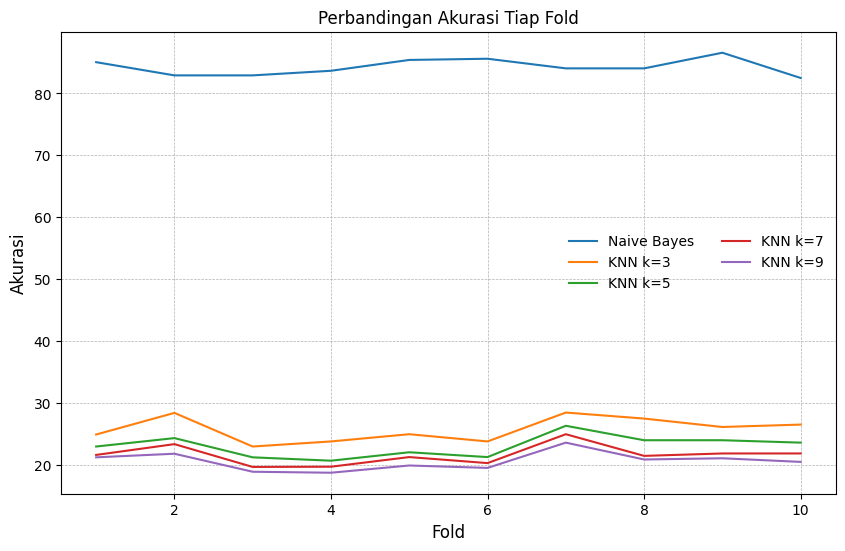

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
kenyamanan = pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/10 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

kenyamanan

,1,2,3,4,5,6,7,8,9,10,Mean
Naive Bayes,82.7%,80.2%,80.2%,79.8%,83.7%,79.0%,78.0%,80.2%,78.8%,81.5%,80.4%
KNN k=3,26.8%,23.7%,23.5%,27.2%,26.1%,22.8%,24.9%,26.8%,23.9%,25.1%,25.1%
KNN k=5,23.7%,20.6%,21.6%,22.4%,23.2%,20.4%,22.8%,24.1%,22.2%,20.8%,22.2%
KNN k=7,21.4%,18.1%,19.0%,21.2%,21.0%,19.1%,21.6%,21.8%,21.0%,19.3%,20.3%
KNN k=9,21.2%,16.1%,18.4%,20.2%,19.6%,17.9%,20.2%,20.4%,20.4%,17.5%,19.2%


## Fasilitas

In [ ]:
result = {}

for name, pipeline in pipelines:
  result[name] = {
      'cm' : [],
      'cr' : []
  }

  for train_index, test_index in kf.split(X_tfidf, datas['fasilitas']):
    x_train, x_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = datas['fasilitas'][train_index], datas['fasilitas'][test_index]

    model_fit = pipeline.fit(x_train, y_train)
    labels = model_fit.predict(x_test)
    cm = confusion_matrix(y_test, labels)
    cr = classification_report(y_test, labels, output_dict=True)

    result[name]['cm'].append(cm)
    result[name]['cr'].append(cr)

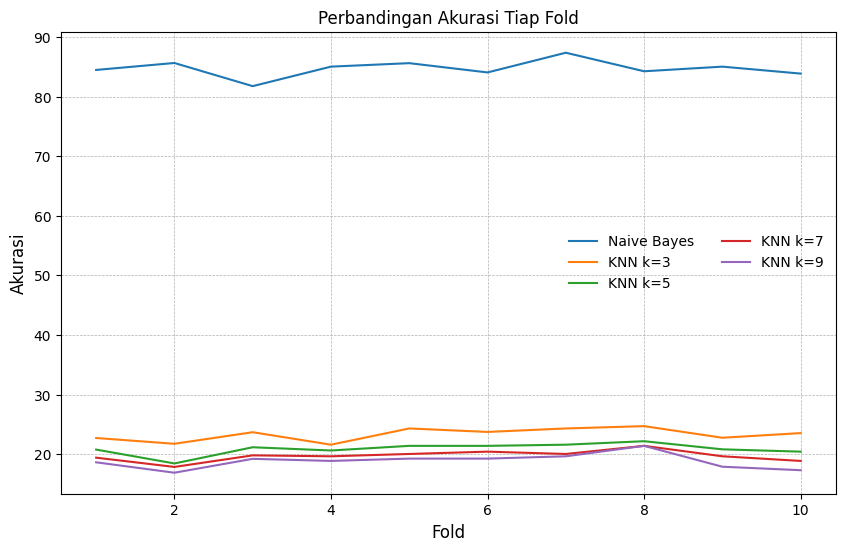

In [ ]:
acc = {name: [cr['accuracy'] for cr in metrik['cr']] for name, metrik in result.items()}

plt.figure(figsize=(10, 6))
for name, akurasi in acc.items():
  plt.plot(range(1,6), [x*100 for x in akurasi], label=name)
plt.title('Perbandingan Akurasi Tiap Fold')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.legend(ncol=2, frameon=False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
fasilitas = pd.concat([
    pd.DataFrame(acc, index=[f'{i}' for i in range(1,6)]).applymap(lambda x: f'{x * 100:.1f}%'),
    pd.DataFrame([[sum(acc[i])/10 for i in acc]], columns=[i for i in acc], index=['Mean']).applymap(lambda x: f'{x * 100:.1f}%')
    ]).transpose()

fasilitas

,1,2,3,4,5,6,7,8,9,10,Mean
Naive Bayes,84.5%,85.6%,81.7%,85.0%,85.6%,84.0%,87.4%,84.2%,85.0%,83.9%,84.7%
KNN k=3,22.7%,21.7%,23.7%,21.6%,24.3%,23.7%,24.3%,24.7%,22.8%,23.5%,23.3%
KNN k=5,20.8%,18.4%,21.2%,20.6%,21.4%,21.4%,21.6%,22.2%,20.8%,20.4%,20.9%
KNN k=7,19.4%,17.9%,19.8%,19.6%,20.0%,20.4%,20.0%,21.4%,19.6%,18.9%,19.7%
KNN k=9,18.6%,16.9%,19.2%,18.9%,19.3%,19.3%,19.6%,21.4%,17.9%,17.3%,18.8%


# Perbandingan SMOTE Sebelum dan Sesudah KFold

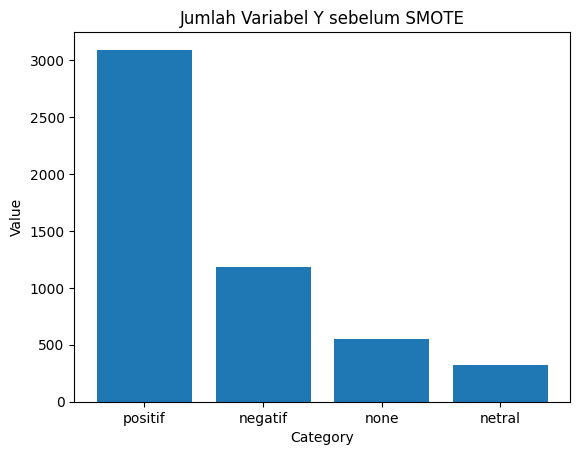

In [ ]:
# Sebelum SMOTE
y_total = datas['pelayanan'].value_counts()

plt.bar(y_total.index, y_total.values)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Jumlah Variabel Y sebelum SMOTE')
plt.show()

## Sebelum

In [ ]:
vectorizer_sebelum = TfidfVectorizer(ngram_range=(1,5))
smote_sebelum = SMOTE()

X_train_vect_sebelum = vectorizer_sebelum.fit_transform(datas['review'])
X_resampled, y_resampled = smote_sebelum.fit_resample(X_train_vect_sebelum, datas['pelayanan'])

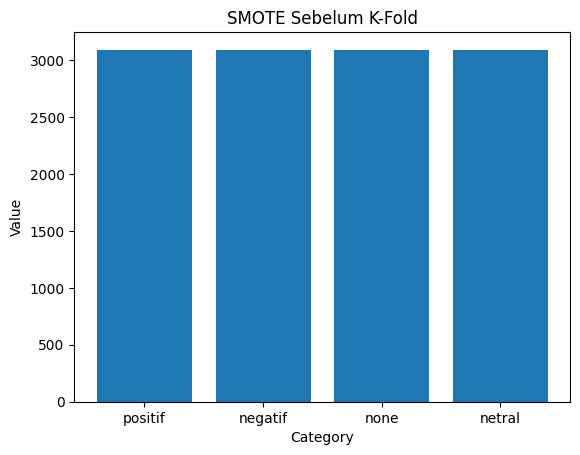

In [ ]:
y_total_smote = y_resampled.value_counts()

plt.bar(y_total_smote.index, y_total_smote.values)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('SMOTE Sebelum K-Fold')
plt.show()

## Sesudah

In [ ]:
kf_sesudah = StratifiedKFold(n_splits=5, shuffle=True, random_state=478)
vectorizer_sesudah = TfidfVectorizer(ngram_range=(1,5))
smote_sesudah = SMOTE()

In [ ]:
y_resampled = 0
i = 0

for train_index, test_index in kf_sesudah.split(datas['review'], datas['pelayanan']):
  i += 1
  x_train, x_test = datas['review'][train_index], datas['review'][test_index]
  y_train, y_test = datas['pelayanan'][train_index], datas['pelayanan'][test_index]

  if i == 1:
    X_train_vect_sesudah = vectorizer_sesudah.fit_transform(x_train)
    X_resampled_sesudah, y_resampled_sesudah = smote_sesudah.fit_resample(X_train_vect_sesudah, y_train)
    y_resampled = y_resampled_sesudah.value_counts()

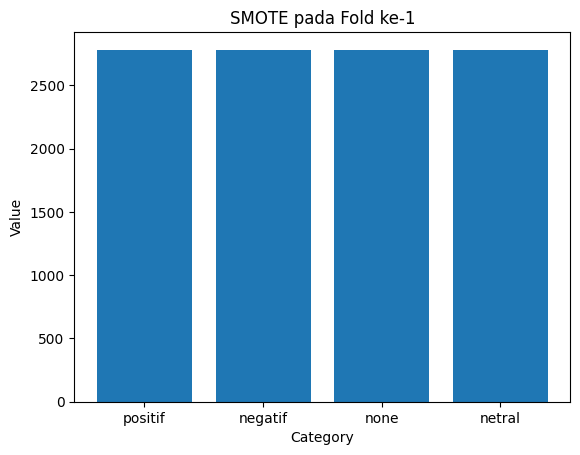

In [ ]:
plt.bar(y_resampled.index, y_resampled.values)
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('SMOTE pada Fold ke-1')
plt.show()

# Learning Curve

In [ ]:
datas = pd.read_excel('/content/000 Cleaned Data Final.xlsx')
datas[['pelayanan', 'administrasi', 'kenyamanan', 'fasilitas']] = datas[['pelayanan', 'administrasi', 'kenyamanan', 'fasilitas']].fillna('none')
datas = datas.loc[~((datas['pelayanan'] == 'none') & (datas['administrasi'] == 'none') & (datas['kenyamanan'] == 'none') & (datas['fasilitas'] == 'none'))]
datas = datas.dropna(subset='review')
datas = datas.reset_index(drop=True)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,5))
X_tfidf = vectorizer.fit_transform(datas['review'])

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=478)
pipeline = imb_Pipeline([
    ('smote', SMOTE(random_state=10)),
    ('nb', naive_bayes.MultinomialNB())
])

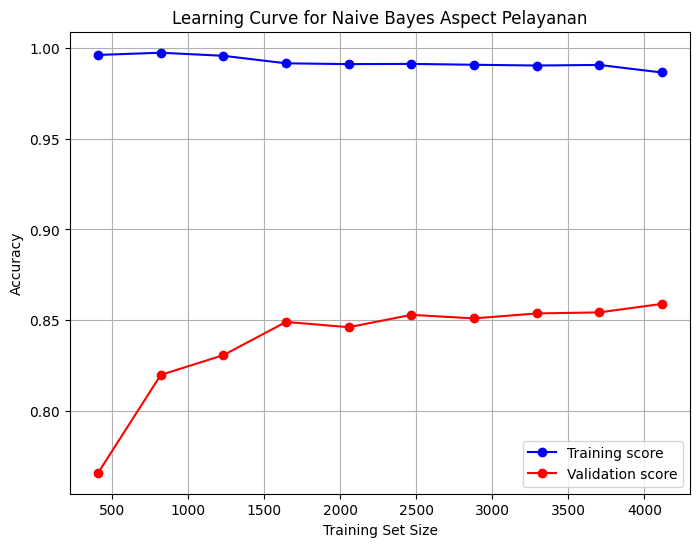

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X_tfidf, datas['pelayanan'],
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', cv=kf)

train_mean = train_scores.mean(axis=1)
val_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='b', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', color='r', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Aspect Pelayanan')
plt.legend(loc='best')
plt.grid(True)
plt.show()

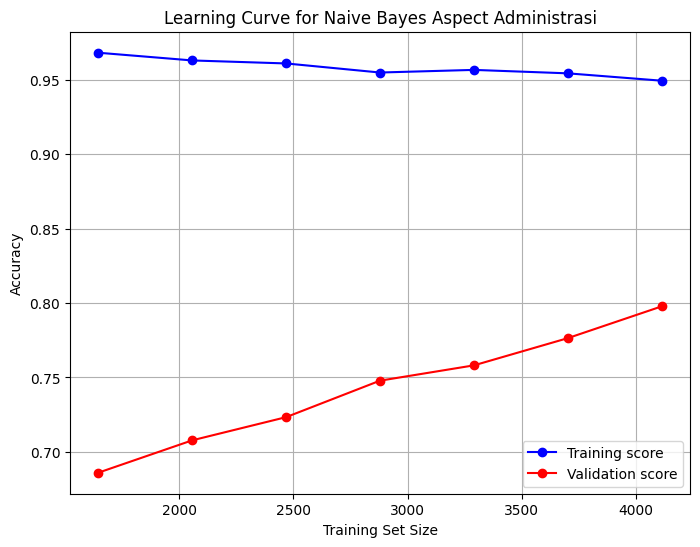

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X_tfidf, datas['administrasi'],
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', cv=kf)

train_mean = train_scores.mean(axis=1)
val_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='b', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', color='r', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Aspect Administrasi')
plt.legend(loc='best')
plt.grid(True)
plt.show()

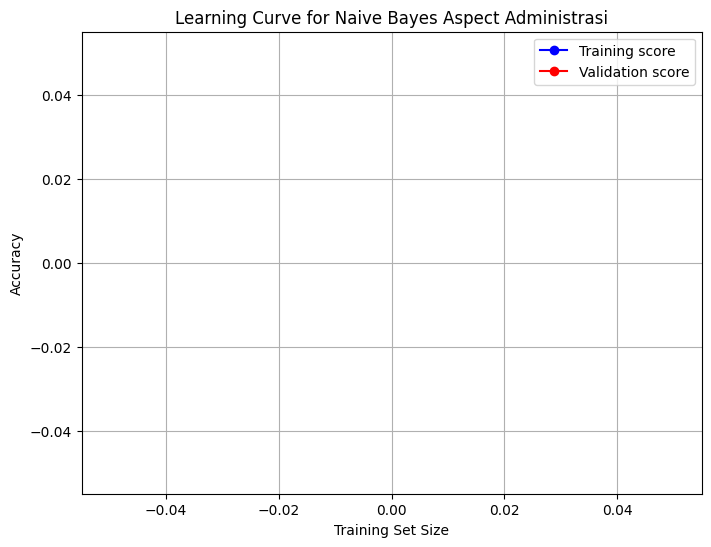

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X_tfidf, datas['kenyamanan'], train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', cv=kf)

train_mean = train_scores.mean(axis=1)
val_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='b', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', color='r', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Aspect Administrasi')
plt.legend(loc='best')
plt.grid(True)
plt.show()

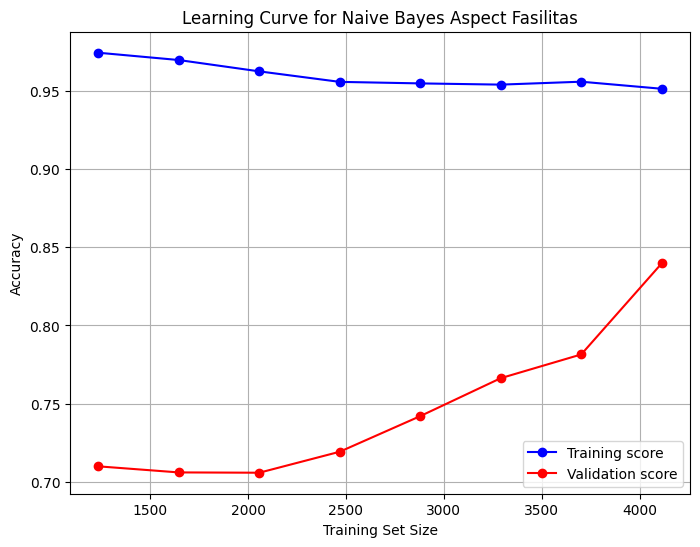

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X_tfidf, datas['fasilitas'],
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', cv=kf)

train_mean = train_scores.mean(axis=1)
val_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='b', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', color='r', marker='o')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Naive Bayes Aspect Fasilitas')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Final Model


In [ ]:
from sklearn.preprocessing import FunctionTransformer

pre = FunctionTransformer(preprocessor)
vectorizer = TfidfVectorizer(ngram_range=(1,5))
smote = SMOTE(random_state=10)
nb1 = naive_bayes.MultinomialNB()
nb2 = naive_bayes.MultinomialNB()
nb3 = naive_bayes.MultinomialNB()
nb4 = naive_bayes.MultinomialNB()

datas = datas.dropna(subset='review')

X_vect = vectorizer.fit_transform(datas['review'])
X_pelayanan, y_pelayanan = smote.fit_resample(X_vect, datas['pelayanan'])
X_administrasi, y_administrasi = smote.fit_resample(X_vect, datas['administrasi'])
X_kenyamanan, y_kenyamanan = smote.fit_resample(X_vect, datas['kenyamanan'])
X_fasilitas, y_fasilitas = smote.fit_resample(X_vect, datas['fasilitas'])

model_pelayanan = nb1.fit(X_pelayanan, y_pelayanan)
model_administrasi = nb2.fit(X_administrasi, y_administrasi)
model_kenyamanan = nb3.fit(X_kenyamanan, y_kenyamanan)
model_fasilitas = nb4.fit(X_fasilitas, y_fasilitas)

In [ ]:
def clf_pipe(text):
  if len(text) != 0:
    text = pre.fit_transform(text)
    text = vectorizer.transform([text])
    pelayanan = model_pelayanan.predict(text)
    administrasi = model_administrasi.predict(text)
    kenyamanan = model_kenyamanan.predict(text)
    fasilitas = model_fasilitas.predict(text)

    result = [
        ('Pelayanan', pelayanan[0]),
        ('Administrasi', administrasi[0]),
        ('Kenyamanan', kenyamanan[0]),
        ('Fasilitas', fasilitas[0])
    ]
  else:
    result = [
        ('Pelayanan', 'none'),
        ('Administrasi', 'none'),
        ('Kenyamanan', 'none'),
        ('Fasilitas', 'none')
    ]

  return result

In [ ]:
text = "tempat parkirnya gratis, dokternya ramah"

hasil = clf_pipe(text)
for aspek, sentimen in hasil:
  print(f"Aspek {aspek}: {sentimen}")

Aspek Pelayanan: positif
Aspek Administrasi: positif
Aspek Kenyamanan: none
Aspek Fasilitas: netral
